# Aplicação de modelos de regressão no *california housing dataset*

---

Segundo projeto de PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Autor: Enzo Bustos da Silva

Dataset: [California Housing](https://www.kaggle.com/camnugent/california-housing-prices)

Nesse notebook vamos discutir um pouco a aplicação de algoritmos de Regressão para tentar predizer qual será o valor mediano de uma casa na região da Califórnia.

Significado das variáveis:

* Id - Id única de cada local
* latitude - latitude do local
* longitude - longitude do local
* median_age - mediana das idades das casas no local
* total_rooms - contagem do total de cômodos na região
* total_bedrooms - contagem do total de quartos na região
* population - população total na região
* households - número total de casas na região
* median_income - mediana da renda das pessoas na região
* median_house_value - mediana dos valores das casas da região - variável-alvo


# Importando bibliotecas e dados:

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col='Id')

# Análise exploratória dos dados:

---

Nessa parte vamos tentar dar uma olhada geral em nossas features para ver como elas se comportam, ver as distribuições, analisar outliers e dados faltantes e pegar um pouco mais das primeiras impressões a respeito dos nossos dados, para isso usando as funções clássicas `head()`, `info()` e `describe()`

In [3]:
df.head(10)

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
Id,,,,,,,,,
15817,-120.85,37.57,27,819,157,451,150,34934,193800
6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
19262,-118.11,33.92,32,1016,190,729,177,43000,151300
19743,-118.12,34.15,35,1760,447,984,384,34167,198200
7272,-120.63,37.41,27,2083,444,1462,479,26439,69100
1155,-121.43,38.54,42,3321,688,1346,658,24618,101300
19827,-122.28,37.53,25,3710,1015,2068,958,35445,286700
7801,-116.99,34.88,23,6060,1165,2920,1072,31528,69000
9867,-117.28,34.17,26,3106,603,1396,576,31736,122200


Com o `head()` já podemos ter um panorâma geral dos nossos dados e ter alguma ideia de como eles se comportam, a princípio parece que temos apenas variáveis númericas, isso provavelmente indica que teremos que futuramente usar algum tipo de normalização dentro dos nossos dados.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 15817 to 9756
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   median_age          14448 non-null  int64  
 3   total_rooms         14448 non-null  int64  
 4   total_bedrooms      14448 non-null  int64  
 5   population          14448 non-null  int64  
 6   households          14448 non-null  int64  
 7   median_income       14448 non-null  int64  
 8   median_house_value  14448 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.1 MB


Confirmamos o que dissemos anteriormente, todos os nossos dados são numéricos e temos uma boa notícia: nosso dataset não apreenta dados faltantes, ou seja, podemos ficar livres da tarefa de fazer alguma imputação de dados.

In [5]:
df.describe()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.563050,35.625804,28.700028,2622.627284,535.628391,1413.978405,496.934109,38747.577450,207556.603267
std,2.008096,2.138690,12.587508,2145.423570,416.800426,1095.060629,376.873380,19091.513037,116441.436255
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,25596.500000,119300.000000
50%,-118.490000,34.250000,29.000000,2116.000000,432.000000,1160.000000,407.000000,35334.000000,179950.000000
75%,-118.000000,37.710000,37.000000,3131.250000,645.250000,1705.000000,602.000000,47500.000000,266100.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,150001.000000,500001.000000


O `describe()` fornece algumas informações valiosas quanto as features numéricas e, como só temos essas features é uma ferramenta muitíssimo poderosa, podemos ver logo de cara algumas discrepâncias entre o 3° quartil e o máximo praticamente todos os dados, eles podem ser outliers, mas também eles podem estar refletindo condições de áreas mais populosas, uma vez que essas áreas vão ter mais prédios e consequentemente maior número de quartos e também um valor mais alto de imóveis.

# Visualização de dados:

---

As técnicas de plotagem de gráficos sempre são úteis para entendermos melhor nosso problema e também poder analisar mais friamente com exatamente quais distribuições estamos trabalhando para termos um melhor tuning de hiper parâmetros.

<Figure size 1080x720 with 0 Axes>

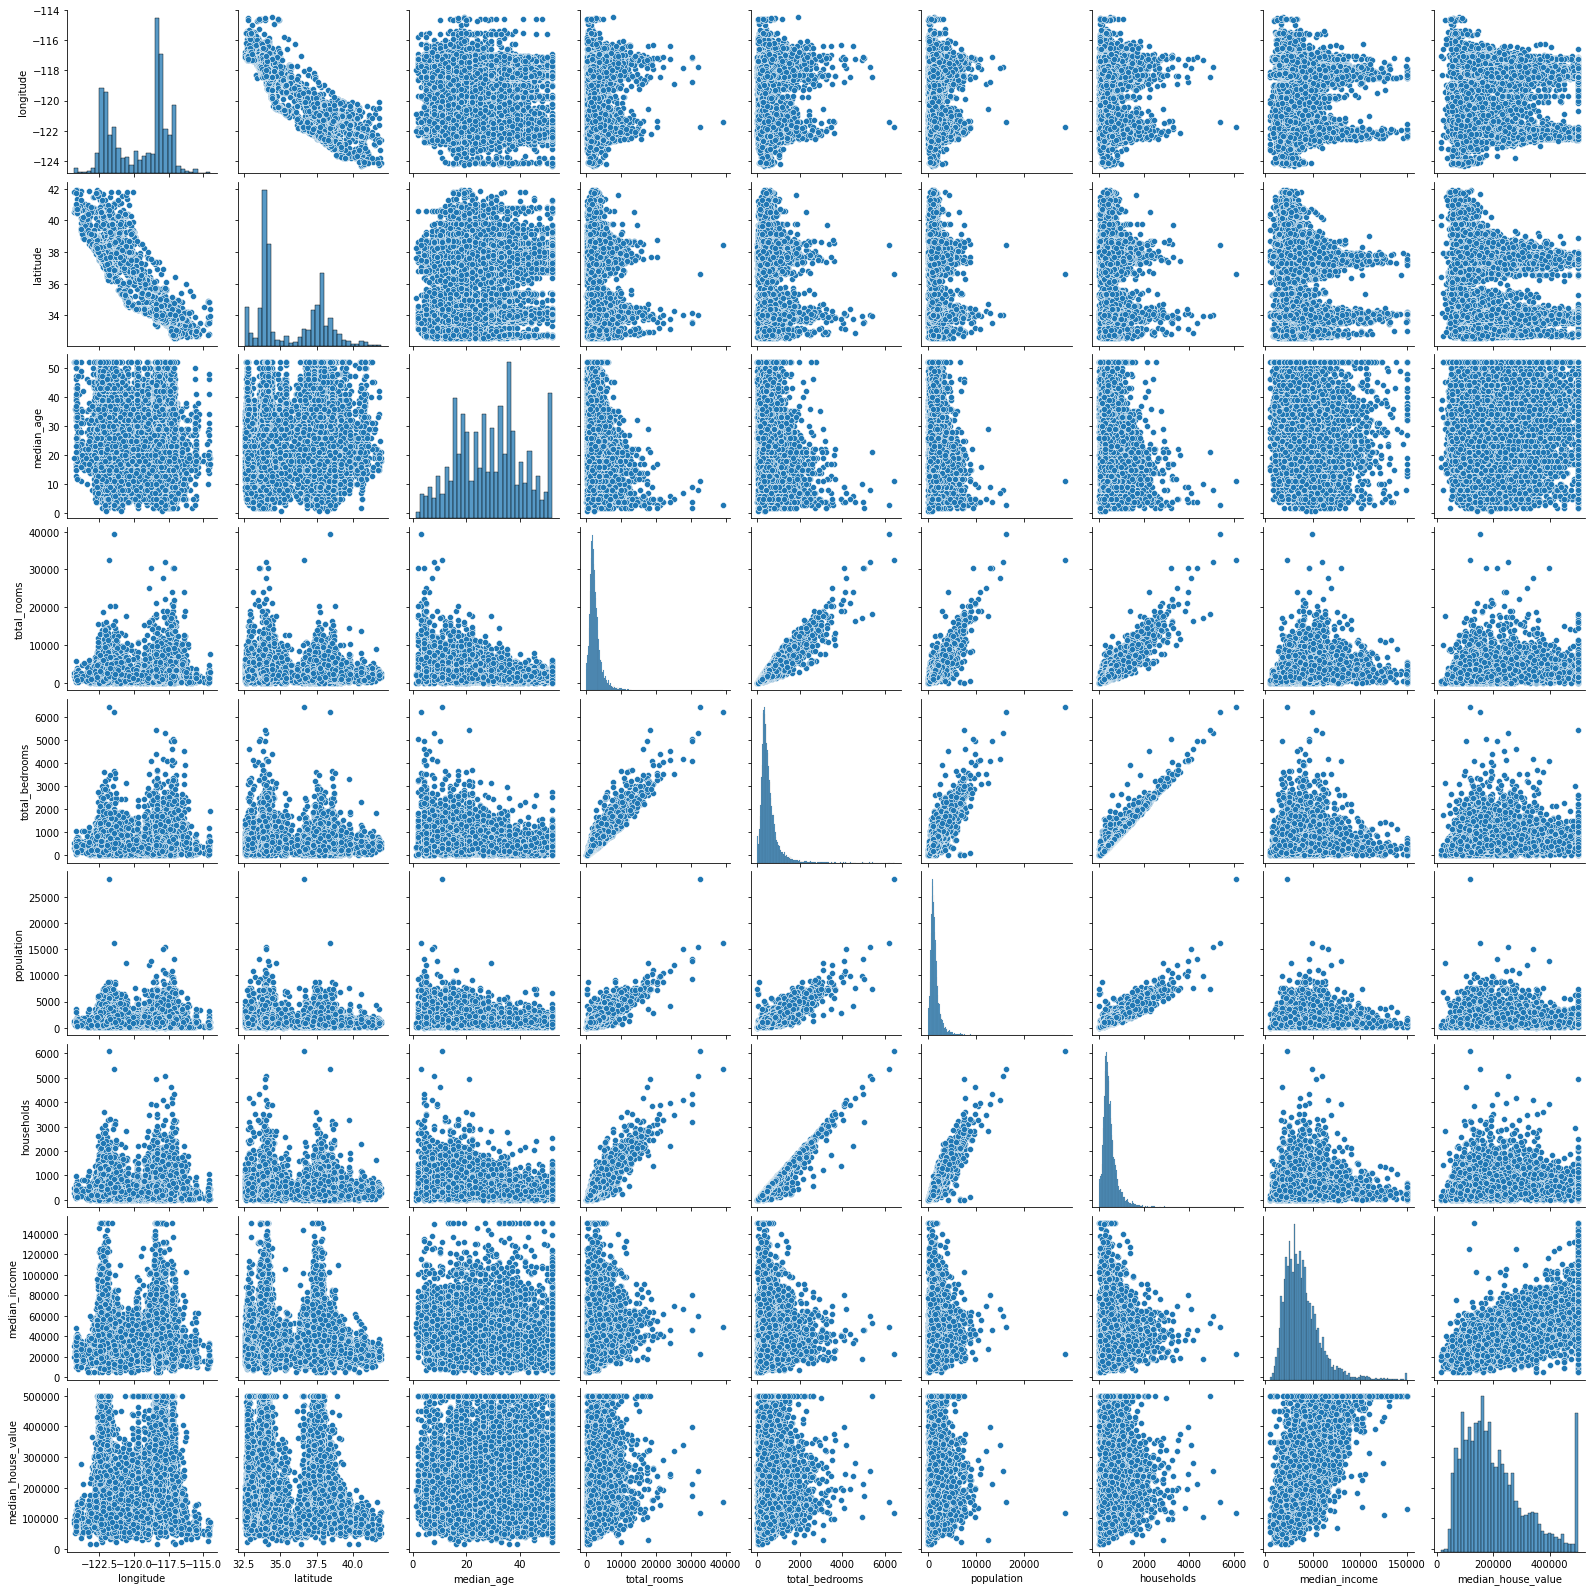

In [6]:
plt.figure(figsize=(15, 10))
sns.pairplot(df)
plt.show()

Talvez esses gráficos tenham ficado um pouco difíceis de serem observados devido ao tamanho, vamos então plotar separadamente as distribuições e histogramas de cada uma das nossas 9 features e também analisar um pouco nossas features que parecem ser linearmente dependentes.

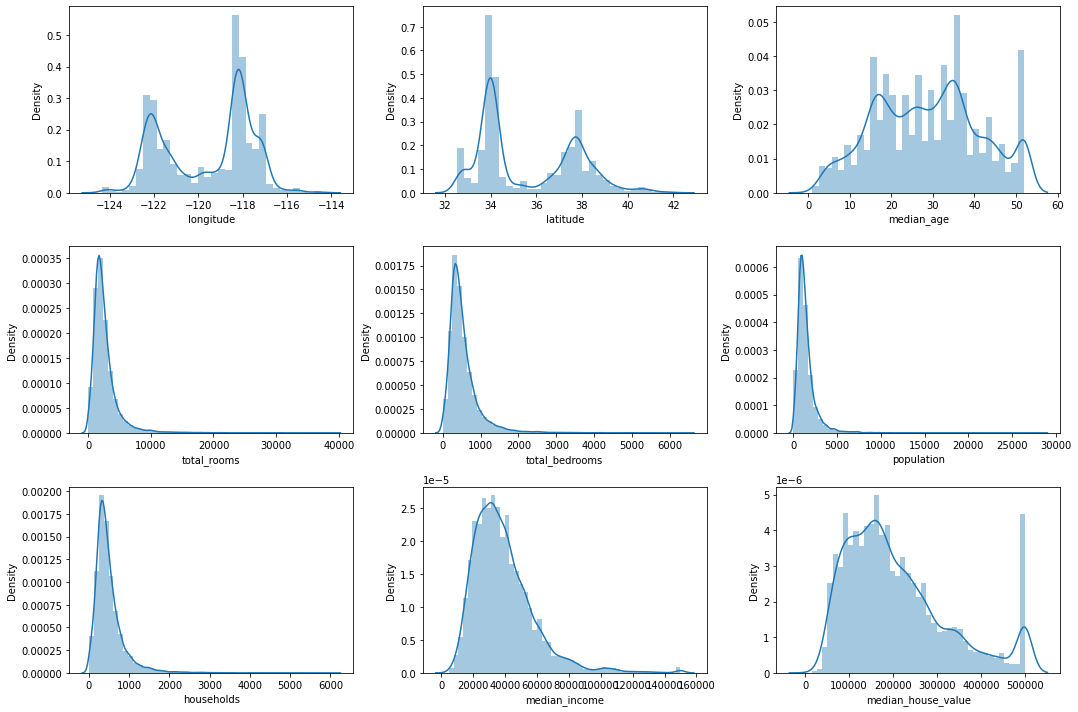

In [7]:
plt.figure(figsize=(15, 10))
for i in range(len(df.columns)):
    plt.subplot(3, 3, i+1)
    sns.distplot(df[df.columns[i]])
plt.tight_layout()
plt.show()

Podemos ver que praticamente todas as features seguem uma distribuição semelhante a normal, porém com a causa direita um pouco mais longa.

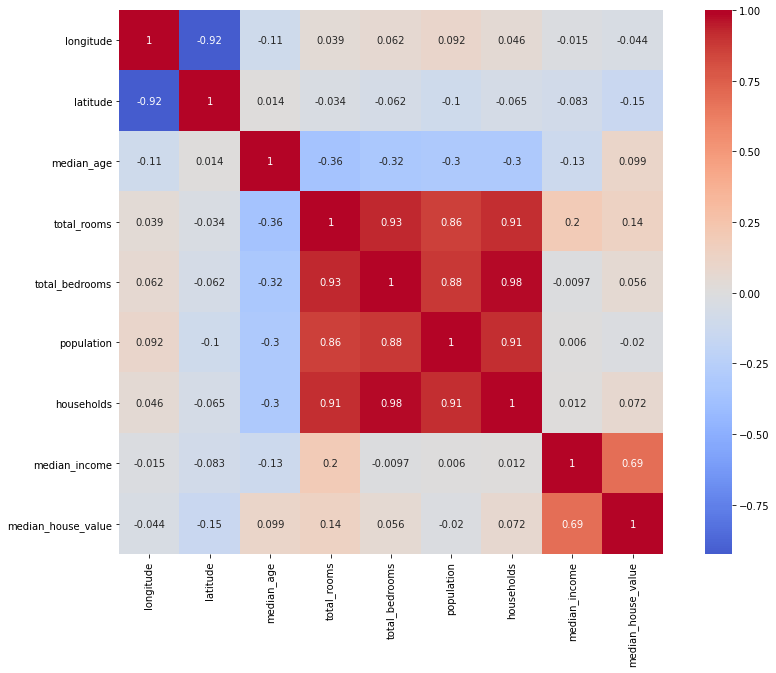

In [8]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, square=True, cmap="coolwarm", center=0, annot=True)
plt.show()

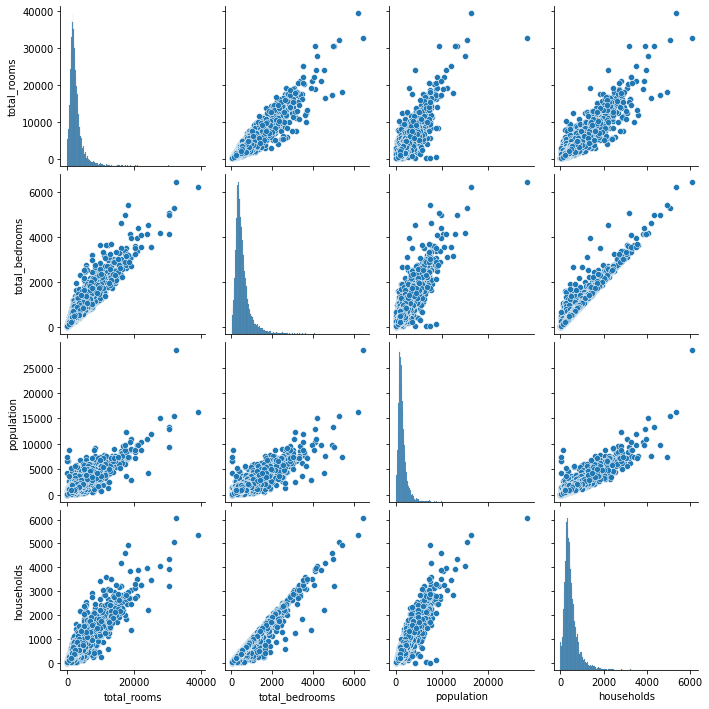

In [9]:
sns.pairplot(df[['total_rooms', 'total_bedrooms', 'population', 'households']])

A partir desse mapa e do zoom do gráfico central podemos ver que existe uma correlação linear fortíssima entre total_rooms, total_bedrooms, population e households; o que faz sentido pela lógica que eu falei anterior mente sobre regiões mais ou menos populosas.

De qualquer forma devemos tomar cuidado com features linearmente dependentes nesse grau para avaliar nossos modelos de regressão uma vez que variáveis linearmente dependentes afetam negativamente nosso modelo.

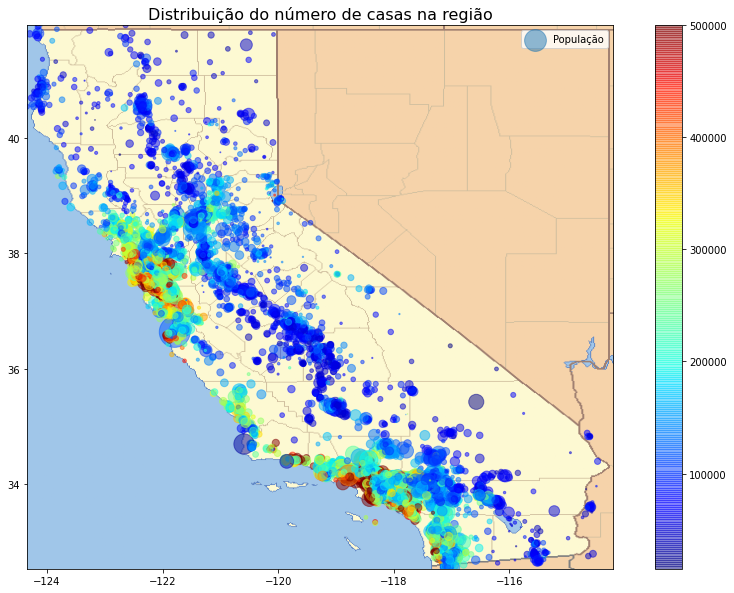

In [10]:
plt.figure(figsize=(15, 10))
img=plt.imread('california.png')
plt.imshow(img,zorder=0,extent=[-124.35, -114.2, 32.54, 41.95])

plt.scatter(x=df['longitude'], y=df['latitude'], alpha=0.5, s=df['population']/30,
            c=df['median_house_value'], cmap=plt.get_cmap("jet"), zorder=1, label='População')

plt.colorbar()
plt.title("Distribuição do número de casas na região", size=16)
plt.legend()

Apenas disso conseguimos inferir que os preços das casas estão muito relacionados com a localização e a densidade populacional local. Com exceção do norte da Califórnia, casas perto do litoral tendem a custar mais caro.

In [11]:
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687604
total_rooms           0.139242
median_age            0.099341
households            0.071622
total_bedrooms        0.055533
population           -0.020434
longitude            -0.044062
latitude             -0.147024
Name: median_house_value, dtype: float64

O fator que parece mais importante para prever esses dados é o `median_income` que dos dá a mediana da renda das pessoas na região, o que faz sentido pensar que regiões que tem pessoas mais ricas, tendem a ter casas com um valor mais alto também.

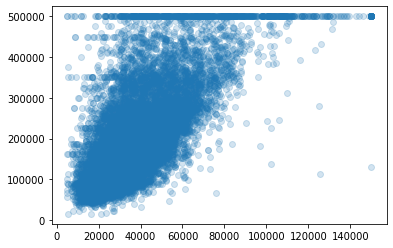

In [12]:
plt.scatter(x=df['median_income'], y=df['median_house_value'], alpha=0.2)

De cara conseguimos ver que existe uma linha esquisita em torno do 500.000 que não segue a tendência de `median_income`, ainda se olharmos com um pouco mais de cautela conseguimos perceber que existe uma linha dessas também em torno de 450.000 e 350.000, provavelmente esses dados estão errados e tratam-se de outliers que vamos remover mais para frente.

# Feature selection

---

Como vimos algumas das nossas variáveis são extremamente dependentes, o que é algo prejudicial para modelos de regressão, pois gera uma das variáveis é um tanto redundante, já que pode ser linearmente deduzida por outra. 

Desse modo, vamos criar que talvez façam mais sentido para o nosso modelo: rooms_per_household e bedrooms_per_room; a primeira vai nos falar quantos quartos existem por conglomerado de casas e a segunda a relação entre dormitórios em relação aos outros cômodos.

In [13]:
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']


corr = df.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687604
rooms_per_household    0.150210
total_rooms            0.139242
median_age             0.099341
households             0.071622
total_bedrooms         0.055533
population            -0.020434
longitude             -0.044062
latitude              -0.147024
bedrooms_per_room     -0.248363
Name: median_house_value, dtype: float64

Como nossas novas variáveis apresentaram uma correlação com o target melhor que as variáveis que deram origem a elas, talvez é interesante remover essas variáveis filhas, uma vez que elas também vão ser linearmente menos dependentes entre si.

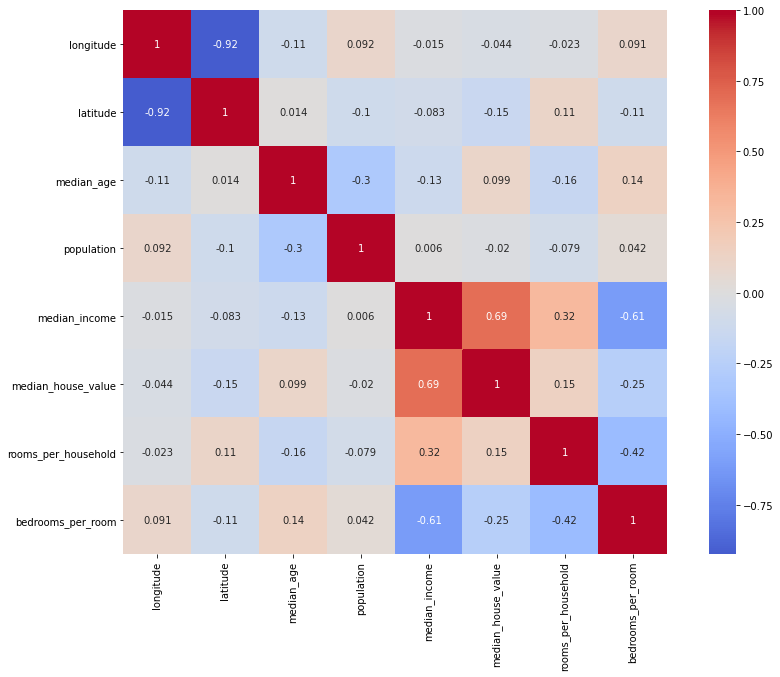

In [14]:
df.drop(['total_rooms', 'total_bedrooms', 'households'], axis=1, inplace=True)

corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, square=True, cmap="coolwarm", center=0, annot=True)
plt.show()

Temos agora variáveis muito mais significativas e que também são mais impactantes para o nosso trabalho de decisão, pois não são tão linearmente dependentes entre si.

# Pré-processamento dos dados:

---

Dentro dessa tarefa devemos limpar nossos dados, podendo assim retirar linhas duplicadas, aplicar auguma normalização no dataset, remover outliers e, com isso deixar nosso DataFrame pronto para ser encaminhado para um modelo de regressão, já deixando também os conjuntos de treino, teste e validação prontos.

In [15]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados.head())
print(len(duplicados))

Empty DataFrame
Columns: [longitude, latitude, median_age, population, median_income, median_house_value, rooms_per_household, bedrooms_per_room]
Index: []
0


Vamos agora remover aquela anomalia que foi notada dentro de `median_house_value`, para isso vou remover as linhas que constam de dados iguais a 500.001 (dados que se acumula e forma aquela linha esquisita).

Para os dados de 350.000 e 450.000 que temos suspeitas de serem outliers, vou colocar ainda uma condição de que para valores de `median_income` menores de 30K valores medianos das casas de 350K serão considerados outliers e o chão será de 40K para casas de mediana valendo 450K

In [16]:
df = df[df['median_house_value'] != 500001]
df = df[(df['median_house_value'] != 350000) & (df['median_income'] > 30000)]
df = df[(df['median_house_value'] != 450000) & (df['median_income'] > 40000)]

Vamos já dividir nossos dados em features X e labels y para podermos aplicar nossa normalização de dados.

In [17]:
#Para alterar a ordem das colunas
df = df[['longitude', 'latitude', 'median_age', 'population', 'median_income',
        'rooms_per_household', 'bedrooms_per_room', 'median_house_value']]

y = pd.DataFrame(df['median_house_value'])
X = df.drop('median_house_value', axis=1)

Agora vamos aplicar uma normalização relativa ao mínimo e máximo, isso pelo fato de que a normalização padrão (na escala Z) não é útil para as métricas que vamos usar posteriormente, que exigem valores positivos, enquanto a StandardScaler converte nossas variáveis para sua recíproca normalizada tirando a média e dividindo pelo desvio padrão.

In [18]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X = pd.DataFrame(x_scaler.fit_transform(X))
X.columns = ['longitude', 'latitude', 'median_age', 'population', 'median_income',
             'rooms_per_household', 'bedrooms_per_room']

y = pd.DataFrame(y_scaler.fit_transform(y))
y.columns = ['median_house_value']

Vamos agora deixar nossos dados divididos em treino e teste para já, na próxima seção aplicarmos os nossos modelos:

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("DataFrame.....shape {} and size {}".format(df.shape, df.size))
print("X_train.......shape {} and size {}".format(X_train.shape, X_train.size))
print("X_test........shape {} and size {}".format(X_test.shape, X_test.size))
print("y_train.......shape {} and size {}".format(y_train.shape, y_train.size))
print("y_test........shape {} and size {}".format(y_test.shape, y_test.size))

DataFrame.....shape (5037, 8) and size 40296
X_train.......shape (4029, 7) and size 28203
X_test........shape (1008, 7) and size 7056
y_train.......shape (4029, 1) and size 4029
y_test........shape (1008, 1) and size 1008


Vamos deixar nossos dados de validação condizentes, para isso vamos aplicar todos os processos de pré-processamento sobre eles também

In [20]:
validation = pd.read_csv('test.csv', index_col='Id')
ids = pd.DataFrame(validation.index)
validation['rooms_per_household'] = validation['total_rooms']/validation['households']
validation['bedrooms_per_room'] = validation['total_bedrooms']/validation['total_rooms']
validation.drop(['total_rooms', 'total_bedrooms', 'households'], axis=1, inplace=True)
validation = pd.DataFrame(x_scaler.transform(validation))
validation.columns = X.columns

print("Validation....shape {} and size {}".format(validation.shape, validation.size))

Validation....shape (6192, 7) and size 43344


# Modelos de Regressão:

---

Nessa parte vamos aplicar diversos modelos de regressão no nosso conjunto de dados e ver como eles performam usando uma métrica passada pelo professor que é o RMSLE (Root Mean Squared Log Error), indo um pouco além preferi também usar outras métricas mais conhecimas como MSE, RMSE e MSLE.

Vamos então importar nossas métricas e alguns modelos de regressão para testar e em seguida fazer uma enxurrada de treinos e testes para ver como cada um deles perfoma.

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

Vamos então criar um dicionário com os nomes dos modelos e algumas métricas e depois poderemos converter esse dicionário em um DataFrame, que será mais fácil para comparar nossos regressores.

Logo abaixo eu fiz também a função `gera_metricas` que será responsável de, para cada regressor, calcular as principais métricas que usaremos.

In [22]:
scores = {
    'Names': [],
    'MSE': [],
    'RMSE': [],
    'MSLE': [],
    'RMSLE': [],
}

def gera_metricas(name, model):
    model.fit(X_train, y_train)
    predicted_scaler = MinMaxScaler(feature_range=(0, 1))
    y_pred = predicted_scaler.fit_transform(model.predict(X_test).reshape(-1, 1))

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))

    scores['Names'].append(name)
    scores['MSE'].append(MSE)
    scores['RMSE'].append(RMSE)
    scores['MSLE'].append(MSLE)
    scores['RMSLE'].append(RMSLE)

Bom vamos agora passar pelo "zoológico" de modelos e sair trainando todos eles, por serem modelos lineares a maioria roda bem rápido então devemos logo ter um DataFrame legal dos modelos.

In [23]:
models = {
    "Linear"            : LinearRegression(n_jobs=-1),
    "Ridge"             : Ridge(alpha=0.1, random_state=42),
    "SGD"               : SGDRegressor(random_state=42),
    "Lasso"             : Lasso(alpha=0.1, random_state=42),
    "Bayesian_Ridge"    : BayesianRidge(), 
    "Random_Forest"     : RandomForestRegressor(30, random_state=42),
    "Decision_Tree"     : DecisionTreeRegressor(max_depth=4, random_state=42),
    "SVR"               : SVR(degree=2, C=10),
    "KNN_Regressor"     : KNeighborsRegressor(n_neighbors=15, p=1, weights='distance'),
    "Gradient_Boosting" : GradientBoostingRegressor(
                                max_depth= 8, max_features=6,
                                min_samples_split=200, random_state=42,
                                n_estimators=100),
}


Chamada para treinarmos e conferirmos as métricas para todos os nossos modelos

In [24]:
for name in models:
    gera_metricas(name, models[name])

models = pd.DataFrame(scores)
models.set_index('Names', inplace=True)
models

,MSE,RMSE,MSLE,RMSLE
Names,,,,
Linear,0.022331,0.149434,0.009421,0.097064
Ridge,0.022514,0.150046,0.009495,0.097442
SGD,0.045855,0.214137,0.021918,0.148047
Lasso,0.272083,0.521615,0.165737,0.407108
Bayesian_Ridge,0.022403,0.149677,0.009450,0.097214
Random_Forest,0.017655,0.132873,0.007992,0.089397
Decision_Tree,0.042432,0.205990,0.019954,0.141260
SVR,0.022385,0.149615,0.010077,0.100383
KNN_Regressor,0.019626,0.140093,0.008737,0.093471


# Análise dos Modelos:

Reservei essa parte para finalmente darmos uma olhada no nosso melhor para podermos compará-lo com o valor correto e, depois aplicar o melhor modelo no nosso set de validação e mandar para o Kaggle da disciplina.

Vamos então achar quais são os melhores modelos, para isso vou achar quais modelos obtem as menores valores de erro para cada uma dessas métricas..

In [25]:
models.loc[models.idxmin()]

,MSE,RMSE,MSLE,RMSLE
Names,,,,
Gradient_Boosting,0.015076,0.122785,0.007036,0.083883
Gradient_Boosting,0.015076,0.122785,0.007036,0.083883
Gradient_Boosting,0.015076,0.122785,0.007036,0.083883
Gradient_Boosting,0.015076,0.122785,0.007036,0.083883


Bom, podemos ver claramente que o GradientBoosting foi o nosso modelo superior, obtendo as menores medidas em absolutamente todas as nossas métricas.

Vou então retreinar esse modelo, só para ficar mais fácil de manipular ele como uma variável.

In [26]:
grad = GradientBoostingRegressor(max_depth= 8, max_features=6,
                                 min_samples_split=200, random_state=42,
                                 n_estimators=100).fit(X_train, y_train)

grad_scaler = MinMaxScaler(feature_range=(0, 1))
y_grboost = pd.DataFrame(grad_scaler.fit_transform(grad.predict(X_test).reshape(-1, 1)))
y_grboost.columns = ['predicted']

Vamos então criar uma tabela contendo todas nossas predições e plottar um gráfico para ver o desempenho dessas funções.

In [27]:
predictions = pd.DataFrame()
predictions['index'] = y_test.index
predictions['number'] = y_grboost.index
y_test.reset_index(drop=True, inplace=True)
predictions['real'] = y_test['median_house_value']
predictions['Gradient_Boosting'] = y_grboost['predicted']

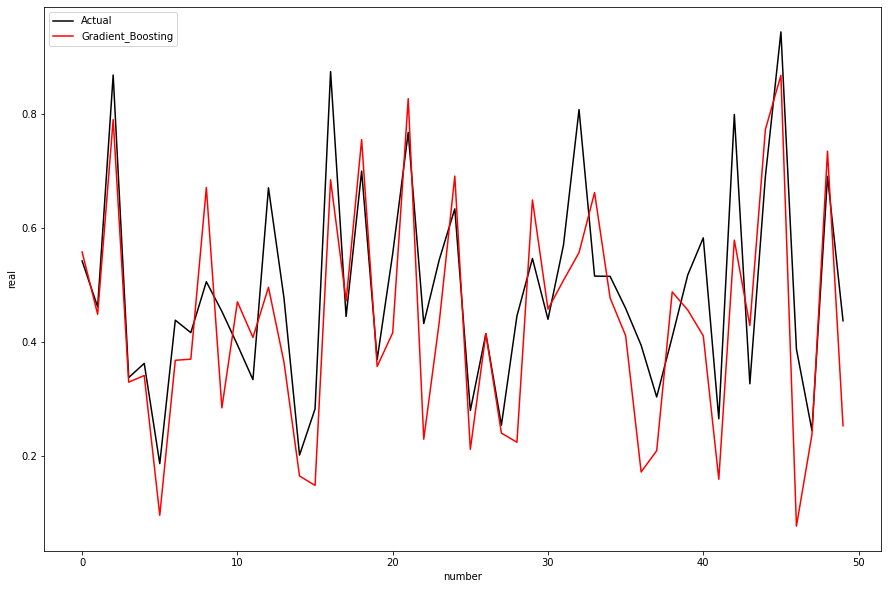

In [28]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='number', y='real', data=predictions.iloc[:50], color='black')
sns.lineplot(x='number', y='Gradient_Boosting', data=predictions.iloc[:50], color='red')
plt.legend(['Actual','Gradient_Boosting'])
plt.show()

Vamos agora aplicar nosso modelo aos nossos dados de validação e criar o arquivo que será computado no Kaggle da disciplina, para isso precisamos reverter a operação de nomalização que fizemos anteriormente.

In [29]:
submit = pd.DataFrame()
submit['Id'] = ids['Id']
submit['median_house_value'] = y_scaler.inverse_transform(grad.predict(validation).reshape(-1, 1))
submit.to_csv('submit.csv', index=False)